In [37]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi

import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools


from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL_feedback.signal_processors as processors

np.random.seed(0)

In [38]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [39]:
def compare_processor_chains(slice_set,chain_1,chain_2,legend_1,legend_2):
    
    orginal = np.array(slice_set.mean_x)
    z = np.array(slice_set.mean_z)
    signal_1 = copy.deepcopy(orginal)
    signal_2 = copy.deepcopy(orginal)
    
    for processor in chain_1:
        signal_1 = processor.process(signal_1,slice_set)
        
    for processor in chain_2:
        signal_2 = processor.process(signal_2,slice_set)
        
    plt.plot(z,orginal,'k-')
    plt.plot(z,signal_1,'b-')
    plt.plot(z,signal_2,'r-')
    plt.show()
    
    #print orginal
    #print signal_1


In [40]:
class SquareSignal(object):
    def __init__(self,z_min, z_max, points, magnitude, charge_sigma):
        self.z_bins=np.linspace(z_min,z_max,points)
        self.mean_z = np.array([(i+j)/2. for i, j in zip(self.z_bins, self.z_bins[1:])])
        self.mean_x = np.zeros(len(self.mean_z))
        for i in range(len(self.mean_z)):
            if i < np.floor(1.*float(points)/6.):
                #print str(i) + ': b'
                self.mean_x[i]=0.
            elif i < np.floor(3.*float(points)/6.):
                #print str(i) + ': c'
                self.mean_x[i]=magnitude
            elif i < np.floor(5.*float(points)/6.):
                #print str(i) + ': d'
                self.mean_x[i]=-1.*magnitude
            else:
                #print str(i) + ': e'
                self.mean_x[i]=0.
        self.n_macroparticles_per_slice = self.gaussian(self.mean_z,0,charge_sigma)
        
        #print self.z_bins
        #print self.mean_x
        #print self.mean_z
        #print self.n_macroparticles_per_slice
        
    def gaussian(self, x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [41]:
n_segments = 4
n_macroparticles = 1000

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376

C = 26658.883
R = C / (2.*np.pi)

s = np.arange(0, n_segments + 1) * C / n_segments

Q_s = 0.000000000001
alpha_0 = [0.0003225]

long_map = LinearMap(alpha_0, C, Q_s)

bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
z_cuts=(-0.25,0.25)
#slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

#initial kick
slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

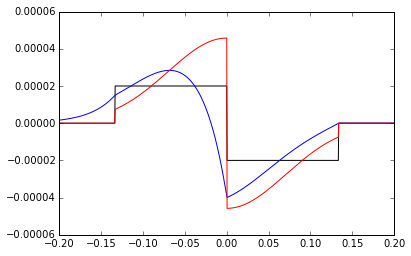

In [42]:
# TODO:
#  -Normalization doesn't work
#  -behaviour of the low pass filter is inverted

f_c = 1e10

signal = SquareSignal(-0.2,0.2,1000,0.00002,0.07)

pickup = [
    processors.PickUp(0.0001,f_c)
]

pickup_old = [
    processors.ChargeWeighter(),
    #processors.LowpassFilter(f_c)
]

compare_processor_chains(signal, pickup, pickup_old,'a','c')